# MLP sobre embeddings CLS (TimeSformer Frozen)

Este notebook entrena un clasificador MLP binario usando embeddings CLS precomputados de TimeSformer.
Entrada: archivos `.mmap` en `processed/`.
Salida: métricas (AUC, F1, Recall, FAR) y artefactos de resultados.


In [1]:
import json
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers para abrir memmaps
# =========================
def infer_1d_length(file_path: Path, dtype: str) -> int:
    nbytes = file_path.stat().st_size
    item = np.dtype(dtype).itemsize
    assert nbytes % item == 0, f"Tamaño de archivo no calza con dtype={dtype}"
    return nbytes // item

def open_y(file_path: Path, dtype="int8"):
    N = infer_1d_length(file_path, dtype)
    return np.memmap(file_path, mode="r", dtype=dtype, shape=(N,))

def open_X(file_path: Path, N: int, D: int, dtype="float16"):
    nbytes = file_path.stat().st_size
    item = np.dtype(dtype).itemsize
    expected = N * D * item
    assert nbytes == expected, f"X size mismatch. got={nbytes}, expected={expected} (N={N}, D={D}, dtype={dtype})"
    return np.memmap(file_path, mode="r", dtype=dtype, shape=(N, D))

# =========================
# Cargar manifest VideoCLIP/XCLIP
# =========================
PROCESSED = Path("processed")
MANIFEST_PATH = PROCESSED / "manifest_xclip_video.json"
assert MANIFEST_PATH.exists(), f"No existe {MANIFEST_PATH}"

with open(MANIFEST_PATH, "r") as f:
    manifest = json.load(f)

files = manifest["files"]
D = int(manifest["embedding_dim"])

X_DTYPE = manifest.get("x_dtype", "float16")
Y_DTYPE = manifest.get("y_dtype", "int8")

print("Model:", manifest["model"])
print("T:", manifest["T"], "IMG_SIZE:", manifest["img_size"], "D:", D)
print("dtypes -> X:", X_DTYPE, "| y:", Y_DTYPE)

# Abrir y primero (para inferir N)
y_train = open_y(Path(files["y_train"]), dtype=Y_DTYPE)
y_val   = open_y(Path(files["y_val"]), dtype=Y_DTYPE)
y_test  = open_y(Path(files["y_test"]), dtype=Y_DTYPE)

N_train, N_val, N_test = len(y_train), len(y_val), len(y_test)
print("N_train, N_val, N_test:", N_train, N_val, N_test)

# Abrir X con shapes correctas (N, D)
X_train = open_X(Path(files["X_train"]), N_train, D, dtype=X_DTYPE)
X_val   = open_X(Path(files["X_val"]),   N_val,   D, dtype=X_DTYPE)
X_test  = open_X(Path(files["X_test"]),  N_test,  D, dtype=X_DTYPE)

print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)

# sanity: distribución
print("y_train counts:", np.bincount(np.array(y_train, dtype=np.int64)))
print("y_val counts:",   np.bincount(np.array(y_val, dtype=np.int64)))
print("y_test counts:",  np.bincount(np.array(y_test, dtype=np.int64)))



DEVICE: cuda
Model: microsoft/xclip-base-patch32
T: 8 IMG_SIZE: 224 D: 512
dtypes -> X: float16 | y: int8
N_train, N_val, N_test: 106527 19793 19036
X_train shape: (106527, 512) dtype: float16
y_train counts: [54009 52518]
y_val counts: [10720  9073]
y_test counts: [9141 9895]


### Paso X — Carga del *manifest* y apertura de embeddings con `memmap` (train/val/test)

Esta celda **carga el archivo `manifest.json`** del experimento y luego **abre (sin cargar a RAM)** los archivos binarios (`.bin`/`.dat`) que contienen:

- `y_train`, `y_val`, `y_test`: etiquetas (0/1) guardadas como vector 1D (`int8`).
- `X_train`, `X_val`, `X_test`: embeddings del codificador guardados como matriz 2D (`float16`) de forma `(N, D)`.

La idea central es usar **`np.memmap`** para trabajar con datasets grandes: se mapean desde disco y se leen “on demand”.


### Paso X — Construcción del `Dataset` y `DataLoader` para embeddings (PyTorch)

#### ¿Qué se hace en esta celda?
Esta celda define un `Dataset` personalizado que envuelve los `memmap` (`X_*`, `y_*`) y luego crea los `DataLoader` de **train / val / test** para alimentar el MLP.

Aquí se pasa de:
- Datos almacenados en disco (`np.memmap`)
a
- Tensores PyTorch listos para entrenamiento por batch.


In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, X_mm, y_mm):
        self.X = X_mm
        self.y = y_mm

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        x = np.asarray(self.X[i], dtype=np.float32)              # (D,)
        y = np.float32(self.y[i])                                # 0/1 en float32
        return torch.from_numpy(x), torch.tensor(y)


BATCH_SIZE = 512
NUM_WORKERS = 2

pin = (DEVICE == "cuda")

train_loader = DataLoader(
    EmbeddingDataset(X_train, y_train),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=4 if NUM_WORKERS > 0 else None,
)

val_loader = DataLoader(
    EmbeddingDataset(X_val, y_val),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=4 if NUM_WORKERS > 0 else None,
)

test_loader = DataLoader(
    EmbeddingDataset(X_test, y_test),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=4 if NUM_WORKERS > 0 else None,
)


### Paso X — Definición del clasificador MLP y configuración de entrenamiento

Aquí se define el **clasificador supervisado** que opera sobre los embeddings `(N, D)` generados por el encoder.  
El encoder ya está congelado; este MLP aprende a mapear cada embedding → probabilidad de anomalía.

Se configuran además:
- función de pérdida,
- optimizador,
- y se instancia el modelo en el dispositivo (`CPU` o `GPU`).






In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

model = MLP(in_dim=D).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

print(model)


/home/DIINF/dvaldes/venvs/tesis/lib/python3.10/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


MLP(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


### Paso X — Función de evaluación (`eval_loader`)

#### ¿Qué se hace en estas celdas?
 Se define `eval_loader(...)`, una función que:
- ejecuta el modelo en modo evaluación sobre un `DataLoader`,
- obtiene probabilidades,
- calcula métricas (AUC, F1, Recall, FAR),
- y devuelve además los vectores `(y, p)` para análisis posterior.

In [4]:
def eval_loader(model, loader, threshold=0.5):
    model.eval()
    ys, ps = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            logits = model(xb)
            prob = torch.sigmoid(logits)

            ys.append(yb.detach().cpu().numpy())
            ps.append(prob.detach().cpu().numpy())

    y = np.concatenate(ys)
    p = np.concatenate(ps)

    auc = roc_auc_score(y, p)
    yhat = (p >= threshold).astype(int)

    f1 = f1_score(y, yhat)
    rec = recall_score(y, yhat)

    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    far = fp / (fp + tn + 1e-9)

    return {"auc": auc, "f1": f1, "recall": rec, "far": far}, (y, p)


### Paso X — loop de entrenamiento con *early stopping*

#### ¿Qué se hace en estas celdas?

Se ejecuta el entrenamiento por épocas:
- forward → loss → backward → update,
- evaluación en validación por época,
- *early stopping* basado en **val AUC**,
- y finalmente se restaura el mejor modelo (según AUC de validación).

In [5]:
EPOCHS = 10
PATIENCE = 3

best_auc = -1.0
best_state = None
bad = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        losses.append(float(loss.detach().cpu().item()))

    train_loss = sum(losses) / max(1, len(losses))
    val_metrics, _ = eval_loader(model, val_loader, threshold=0.5)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_auc={val_metrics['auc']:.4f} val_f1={val_metrics['f1']:.4f} "
          f"val_recall={val_metrics['recall']:.4f} val_far={val_metrics['far']:.4f}")

    if val_metrics["auc"] > best_auc + 1e-4:
        best_auc = val_metrics["auc"]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping.")
            break

# Restaurar mejor modelo
assert best_state is not None
model.load_state_dict(best_state)
print("Best val AUC:", best_auc)


Epoch 01 | train_loss=0.6938 | val_auc=0.4170 val_f1=0.0009 val_recall=0.0004 val_far=0.0035
Epoch 02 | train_loss=0.6930 | val_auc=0.5144 val_f1=0.0258 val_recall=0.0132 val_far=0.0106
Epoch 03 | train_loss=0.6930 | val_auc=0.6299 val_f1=0.1553 val_recall=0.0878 val_far=0.0369
Epoch 04 | train_loss=0.6926 | val_auc=0.6512 val_f1=0.1485 val_recall=0.0863 val_far=0.0645
Epoch 05 | train_loss=0.6925 | val_auc=0.5508 val_f1=0.2902 val_recall=0.2013 val_far=0.1574
Epoch 06 | train_loss=0.6920 | val_auc=0.4800 val_f1=0.2299 val_recall=0.1388 val_far=0.0578
Epoch 07 | train_loss=0.6915 | val_auc=0.5601 val_f1=0.3403 val_recall=0.2421 val_far=0.1531
Early stopping.
Best val AUC: 0.6511685585902736


## Paso 1 — Evaluación de desempeño (Validation y Test)

### ¿Qué se hace en esta celda?
Se evalúa el clasificador MLP sobre los splits **val** y **test** usando `eval_loader`, obteniendo:
- métricas principales (AUC, F1, Recall, FAR)
- los vectores `(y, p)` para análisis posterior (ROC y matriz de confusión).

### Resultado esperado
- Impresión de métricas por split
- Variables listas: `val_metrics`, `test_metrics`, `y_val_np`, `p_val_np`, `y_test_np`, `p_test_np`


In [6]:
val_metrics, (y_val_np, p_val_np) = eval_loader(model, val_loader, threshold=0.5)
test_metrics, (y_test_np, p_test_np) = eval_loader(model, test_loader, threshold=0.5)

print("VAL:", val_metrics)
print("TEST:", test_metrics)


VAL: {'auc': 0.6511685585902736, 'f1': 0.14847824025789325, 'recall': 0.08630001102171278, 'far': np.float64(0.06445895522387458)}
TEST: {'auc': 0.48317376761874314, 'f1': 0.050302168503377175, 'recall': 0.028600303183425973, 'far': np.float64(0.11749261568754868)}


## Paso 2 — Matriz de confusión (Test) + métrica de Accuracy

### ¿Qué se hace en esta celda?
Se fija un umbral (`0.5`) para convertir probabilidades en clases 0/1, y se calcula:
- `Accuracy`
- Matriz de confusión: TN, FP, FN, TP

### Resultado esperado
- Matriz de confusión (tabla 2×2)
- Valores TN/FP/FN/TP impresos
- Accuracy impresa


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

threshold = 0.5
y_test_bin = (p_test_np >= threshold).astype(int)

cm = confusion_matrix(y_test_np, y_test_bin)
tn, fp, fn, tp = cm.ravel()

acc_test = accuracy_score(y_test_np, y_test_bin)

cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

print("\n=== Confusion Matrix (TEST) ===")
display(cm_df)
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print(f"Accuracy (TEST) = {acc_test:.4f}")




=== Confusion Matrix (TEST) ===


,Pred 0,Pred 1
Actual 0,8067,1074
Actual 1,9612,283


TN=8067 FP=1074 FN=9612 TP=283
Accuracy (TEST) = 0.4386


## Paso 3 — Curva ROC (Test)

### ¿Qué se hace en esta celda?
Se construye y grafica la curva ROC con:
- FPR (False Positive Rate)
- TPR (True Positive Rate)

### Resultado esperado
- Gráfico ROC del split test


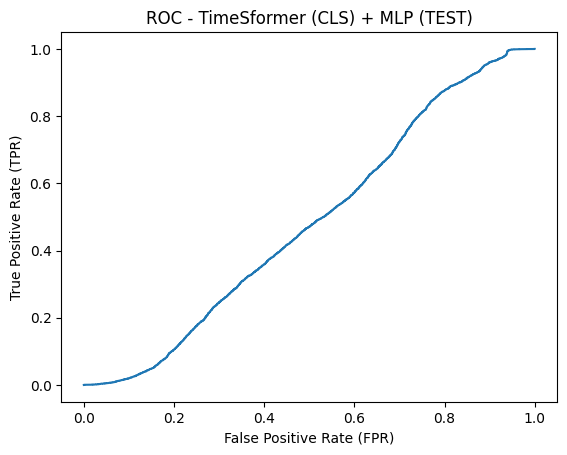

In [8]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_np, p_test_np)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC - TimeSformer (CLS) + MLP (TEST)")
plt.show()


## Paso 4 — Tabla resumen de desempeño (Validation vs Test) y guardado

### ¿Qué se hace en esta celda?
Se genera una tabla final con métricas de desempeño (val/test) y se guarda en CSV.

### Resultado esperado
- DataFrame `results_df`
- Archivo CSV exportado a `processed/`


In [9]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Asegurar threshold explícito
threshold = 0.5

MODEL_LABEL = f"{manifest.get('model', 'VideoCLIP')} + MLP"

results_df = pd.DataFrame({
    "Modelo": [MODEL_LABEL, MODEL_LABEL],
    "Split": ["Validation", "Test"],
    "AUC": [val_metrics["auc"], test_metrics["auc"]],
    "F1": [val_metrics["f1"], test_metrics["f1"]],
    "Recall": [val_metrics["recall"], test_metrics["recall"]],
    "FAR": [val_metrics["far"], test_metrics["far"]],
    "Accuracy": [
        accuracy_score(y_val_np, (p_val_np >= threshold).astype(int)),
        accuracy_score(y_test_np, (p_test_np >= threshold).astype(int)),
    ],
}).round(4)

print(f"\n=== Resultados de Desempeño: {MODEL_LABEL} ===\n")
display(results_df)

out_csv = PROCESSED / "results_performance_videoclip_mlp.csv"
results_df.to_csv(out_csv, index=False)
print("Guardado:", out_csv)




=== Resultados de Desempeño: microsoft/xclip-base-patch32 + MLP ===



,Modelo,Split,AUC,F1,Recall,FAR,Accuracy
0,microsoft/xclip-base-patch32 + MLP,Validation,0.6512,0.1485,0.0863,0.0645,0.5463
1,microsoft/xclip-base-patch32 + MLP,Test,0.4832,0.0503,0.0286,0.1175,0.4386


Guardado: processed/results_performance_videoclip_mlp.csv


In [10]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

def uniform_sample_indices(start_f: int, end_f: int, T: int):
    n = max(1, end_f - start_f)
    idx = np.linspace(0, n - 1, T).round().astype(int)
    return (start_f + idx).astype(int)

class ClipDataset(Dataset):
    def __init__(self, df, T=8, img_size=224):
        self.df = df.reset_index(drop=True)
        self.T = T
        self.img_size = img_size
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["path"]
        start_f = int(row["start_frame"])
        end_f   = int(row["end_frame"])
        y = int(row["y"])

        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            raise RuntimeError(f"No pude abrir video: {path}")

        frame_ids = uniform_sample_indices(start_f, end_f, self.T)

        frames = []
        last_good = None
        for fid in frame_ids:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fid))
            ok, frame = cap.read()

            if not ok:
                frame = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8) if last_good is None else last_good
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
                last_good = frame

            frames.append(frame)

        cap.release()

        arr = np.stack(frames).astype(np.float32) / 255.0
        arr = (arr - self.mean) / self.std
        arr = np.transpose(arr, (3, 0, 1, 2))  # (C,T,H,W)
        clip = torch.from_numpy(arr)

        return clip, torch.tensor(y, dtype=torch.long)


## Paso 5 — Métricas operativas del encoder (latencia, ms/frame, FPS)

### ¿Qué se hace en esta celda?
Se mide el tiempo de inferencia del encoder TimeSformer sobre batches reales:
- warmup (no medir los primeros batches)
- medición promedio por batch
- latencia por clip
- ms/frame
- FPS efectivo

### Resultado esperado
- Impresión: avg s/batch, ms/clip, ms/frame, FPS


In [11]:
# =========================
# Paso 5 — Métricas operativas del encoder (VideoCLIP / XCLIP)
# latencia, ms/clip, ms/frame, FPS
# =========================
import time
import torch
from transformers import XCLIPModel

# 1) Variables desde el manifest (ajusta claves si tu manifest usa otros nombres)
T = int(manifest.get("T", manifest.get("clip_len", 16)))
IMG_SIZE = int(manifest.get("img_size", manifest.get("image_size", 224)))

# Importante: que el checkpoint sea el mismo que usaste al generar embeddings
XCLIP_CKPT = manifest.get("model", manifest.get("ckpt", "microsoft/xclip-base-patch32"))

print("\n=== Paso 5: Métricas Operativas (Encoder VideoCLIP/XCLIP) ===")
print("Checkpoint:", XCLIP_CKPT)
print("T:", T, "IMG_SIZE:", IMG_SIZE)
print("DEVICE:", DEVICE)

# 2) Cargar encoder
encoder = XCLIPModel.from_pretrained(XCLIP_CKPT).to(DEVICE)
encoder.eval()

@torch.no_grad()
def xclip_video_embeds_unimodal(encoder: XCLIPModel, pixel_values: torch.Tensor) -> torch.Tensor:
    """
    pixel_values: (B, T, C, H, W)
    return: (B, D) video embedding (solo visión)
    """
    B, T, C, H, W = pixel_values.shape

    # XCLIP vision_model espera (N, C, H, W) -> procesamos por frame
    flat = pixel_values.reshape(B * T, C, H, W).contiguous()

    vision_out = encoder.vision_model(pixel_values=flat)

    # pooler_output suele estar disponible; fallback a tuple index si aplica
    if isinstance(vision_out, (tuple, list)):
        frame_pooled = vision_out[1]
    else:
        frame_pooled = vision_out.pooler_output

    # Proyección visual a D
    frame_embeds = encoder.visual_projection(frame_pooled)  # (B*T, D)

    # Agregar temporalmente por promedio (simple y consistente)
    frame_embeds = frame_embeds.view(B, T, -1)             # (B, T, D)
    video_embed = frame_embeds.mean(dim=1)                 # (B, D)
    return video_embed

@torch.no_grad()
def measure_xclip_latency(
    encoder: XCLIPModel,
    T: int,
    img_size: int,
    device: str,
    batch_size: int = 8,
    n_batches: int = 200,
    warmup: int = 10,
):
    """
    Mide latencia del forward del encoder usando input dummy.
    Retorna:
      - time_per_batch_s
      - time_per_clip_s
      - time_per_frame_s
      - fps_effective
    """
    dummy = torch.randn(batch_size, T, 3, img_size, img_size, device=device)

    # warmup
    for _ in range(warmup):
        _ = xclip_video_embeds_unimodal(encoder, dummy)

    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(n_batches):
        _ = xclip_video_embeds_unimodal(encoder, dummy)

    if device == "cuda":
        torch.cuda.synchronize()

    elapsed = time.time() - start

    time_per_batch_s = elapsed / n_batches
    time_per_clip_s  = time_per_batch_s / batch_size
    time_per_frame_s = time_per_clip_s / T
    fps_effective    = 1.0 / time_per_frame_s

    return {
        "batches_measured": int(n_batches),
        "batch_size": int(batch_size),
        "T": int(T),
        "img_size": int(img_size),
        "time_per_batch_s": float(time_per_batch_s),
        "time_per_clip_s": float(time_per_clip_s),
        "time_per_frame_s": float(time_per_frame_s),
        "fps_effective": float(fps_effective),
    }

# 3) Ejecutar medición
op = measure_xclip_latency(
    encoder=encoder,
    T=T,
    img_size=IMG_SIZE,
    device=DEVICE,
    batch_size=8,   # ajusta si te falta VRAM
    n_batches=200,
    warmup=10,
)

# 4) Variables que usarán tus siguientes pasos (igual que en TimeSformer)
time_per_clip  = op["time_per_clip_s"]
time_per_frame = op["time_per_frame_s"]
fps_effective  = op["fps_effective"]

print("\nBatches medidos:", op["batches_measured"])
print("Batch size:", op["batch_size"])
print(f"Tiempo promedio por batch: {op['time_per_batch_s']:.4f} s")
print(f"Latencia por clip: {time_per_clip*1000:.2f} ms/clip")
print(f"Tiempo por frame: {time_per_frame*1000:.2f} ms/frame")
print(f"FPS efectivo: {fps_effective:.2f} fps")



=== Paso 5: Métricas Operativas (Encoder VideoCLIP/XCLIP) ===
Checkpoint: microsoft/xclip-base-patch32
T: 8 IMG_SIZE: 224
DEVICE: cuda

Batches medidos: 200
Batch size: 8
Tiempo promedio por batch: 0.0683 s
Latencia por clip: 8.54 ms/clip
Tiempo por frame: 1.07 ms/frame
FPS efectivo: 936.57 fps


## Paso 6 — Time-To-Alert (TTA) estimado

### ¿Qué se hace en esta celda?
Se estima un **time-to-alert** aproximado como:
- duración temporal de la ventana (clip) = `T / fps_video`
- + latencia computacional (ms/clip)

### Resultado esperado
- Duración ventana
- Latencia computacional
- TTA estimado


In [12]:
# =========================
# Paso 6 — Time-To-Alert (TTA) estimado
# =========================
# Requiere: T, time_per_clip (calculado en Paso 5)
video_fps = 30  # ajusta si tu fuente es distinta

latencia_clip_ms = time_per_clip * 1000.0
duracion_clip_s = T / video_fps
tta_s = duracion_clip_s + (latencia_clip_ms / 1000.0)

print("\n=== Paso 6: Time-To-Alert (TTA) ===")
print(f"FPS video asumido: {video_fps}")
print(f"Duración ventana (clip): {duracion_clip_s:.3f} s")
print(f"Latencia computacional: {latencia_clip_ms/1000:.3f} s")
print(f"Time-To-Alert estimado: {tta_s:.3f} s")



=== Paso 6: Time-To-Alert (TTA) ===
FPS video asumido: 30
Duración ventana (clip): 0.267 s
Latencia computacional: 0.009 s
Time-To-Alert estimado: 0.275 s


## Paso 7 — Complejidad computacional (FLOPs y parámetros)

### ¿Qué se hace en esta celda?
Se estima:
- GFLOPs del encoder
- número de parámetros

Usando `thop` sobre un tensor dummy con forma compatible.

### Resultado esperado
- GFLOPs
- Params (millones)


In [13]:
# =========================
# Paso 7 — Complejidad computacional (GFLOPs y parámetros) (VideoCLIP / XCLIP unimodal video)
# =========================
from thop import profile
import torch

encoder.eval()

dummy = torch.randn(1, T, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

# Wrapper: THOP llama forward(x) -> devolvemos tensor (B, D)
class XCLIPVideoWrapper(torch.nn.Module):
    def __init__(self, enc):
        super().__init__()
        self.enc = enc
    def forward(self, x):
        # x: (B, T, C, H, W)
        return xclip_video_embeds_unimodal(self.enc, x)  # (B, D)

wrapped = XCLIPVideoWrapper(encoder).to(DEVICE)
flops, params = profile(wrapped, inputs=(dummy,), verbose=False)

print("\n=== Paso 7: Complejidad Computacional (XCLIP Video Unimodal) ===")
print(f"FLOPs: {flops/1e9:.2f} GFLOPs")
print(f"Parámetros: {params/1e6:.2f} M")



=== Paso 7: Complejidad Computacional (XCLIP Video Unimodal) ===
FLOPs: 35.44 GFLOPs
Parámetros: 123.26 M


## Paso 8 — Tabla final integrada (desempeño + operativas) y exportación

### ¿Qué se hace en esta celda?
Se arma una tabla única para reportar en tesis, combinando:
- desempeño (Test)
- métricas operativas (ms/frame, FPS, TTA)
- costo computacional (GFLOPs)

### Resultado esperado
- DataFrame `final_table`
- CSV exportado


In [14]:
# =========================
# Paso 8 — Tabla final integrada (desempeño + operativas) y exportación
# (VideoCLIP / XCLIP + MLP)
# =========================
# Requiere:
# test_metrics, acc_test, tn, fp, fn, tp,
# flops, params, tta_s,
# time_per_frame, fps_effective,
# manifest, Path

import pandas as pd
from pathlib import Path

PROCESSED = Path("processed")

MODEL_NAME = manifest.get("model", "VideoCLIP")
MODEL_LABEL = f"{MODEL_NAME} + MLP"

final_table = pd.DataFrame({
    "Modelo": [MODEL_LABEL],

    # =====================
    # MÉTRICAS DE DESEMPEÑO
    # =====================
    "AUC (Test)": [round(test_metrics["auc"], 4)],
    "F1 (Test)": [round(test_metrics["f1"], 4)],
    "Recall (Test)": [round(test_metrics["recall"], 4)],
    "FAR (Test)": [round(test_metrics["far"], 4)],
    "Accuracy (Test)": [round(float(acc_test), 4)],

    "TN": [int(tn)],
    "FP": [int(fp)],
    "FN": [int(fn)],
    "TP": [int(tp)],

    # =====================
    # MÉTRICAS OPERATIVAS
    # =====================
    "ms/frame": [round(time_per_frame * 1000.0, 2)],
    "FPS": [round(float(fps_effective), 2)],
    "TTA (s)": [round(float(tta_s), 3)],

    "GFLOPs": [round(float(flops / 1e9), 2)],
    "Params (M)": [round(float(params / 1e6), 2)],
})

display(final_table)

# Export específico para VideoCLIP
out_csv = PROCESSED / "final_report_videoclip_full.csv"
final_table.to_csv(out_csv, index=False)

print("Guardado:", out_csv)


,Modelo,AUC (Test),F1 (Test),Recall (Test),FAR (Test),Accuracy (Test),TN,FP,FN,TP,ms/frame,FPS,TTA (s),GFLOPs,Params (M)
0,microsoft/xclip-base-patch32 + MLP,0.4832,0.0503,0.0286,0.1175,0.4386,8067,1074,9612,283,1.07,936.57,0.275,35.44,123.26


Guardado: processed/final_report_videoclip_full.csv
